In [3]:
from quant_rotor.core.sparse.hamiltonian import hamiltonian_sparse
from quant_rotor.core.sparse.hamiltonian_big import hamiltonian_general_sparse, hamiltonian_big_sparse
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general_dense, hamiltonian_big_dense
from quant_rotor.core.dense.de_solve_one_thermal import integration_scheme
import numpy as np
from quant_rotor.models.sparse.support_ham import build_V_in_p
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from quant_rotor.models.dense.stat_mech_thermo import generate_graphs, A, Z, S, heat_capacity, beta_func
from quant_rotor.models.dense.stat_mech_thermo import U as U_stat
import quant_rotor.models.dense.thermofield_boltz_funcs as bz
import opt_einsum as oe
import scipy as sp
from itertools import permutations

In [40]:
site = 5
state = 11
g = 0.5

In [41]:
hamiltonian_sparse(state, site, g)

(<Compressed Sparse Row sparse matrix of dtype 'complex128'
 	with 2823050 stored elements and shape (161051, 161051)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 10 stored elements and shape (11, 11)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 400 stored elements and shape (121, 121)>)

In [15]:
H, K, V = hamiltonian_general_dense(state, site, g)

In [16]:
# K, V = build_V_in_p(state)
# K, V = K.toarray(), V.toarray()

U, _ = bz.thermofield_change_of_basis(K)

K_tilda = bz.H_tilde_maker(K)

V_tensor = V.reshape(state, state, state, state)

I = np.eye(state)
V_prim = oe.contract('pqrs,mw,nv->pmqnrwsv', V_tensor, I, I,  optimize='optimal')

V_grouped = V_prim.reshape(state**2, state**2, state**2, state**2)

V_tilda = oe.contract('Mi,Wj,ijab,aN,bV->MWNV', U, U, V_grouped, U, U, optimize='optimal')

In [17]:
time, energy_TD_TF_CCC, si5_st5_sol_var, _  = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_tilda, V_import=V_tilda)

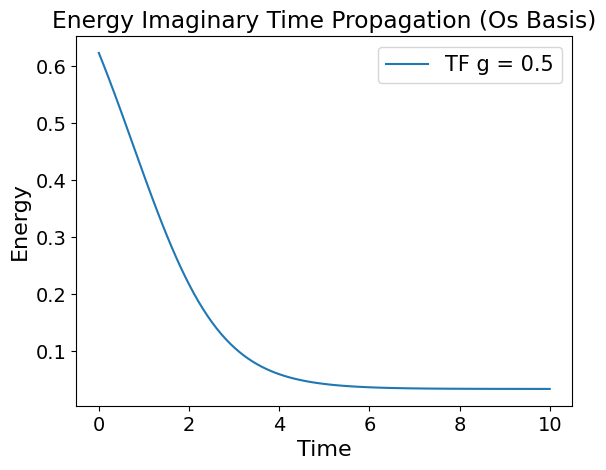

In [18]:
plt.plot(time, -energy_TD_TF_CCC/site, label=f"TF g = {g}")
plt.title("Energy Imaginary Time Propagation (Os Basis)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [4]:
site = 3
state = 3

In [6]:
si5_st5_sol = []
si5_st5_dB = []
si5_st5_ED_Z = []
si5_st5_ED_U = []
beta_array = []
g_array = np.array([0, 0.1, 0.2, 0.3, 0.5])

for g_index, g in enumerate(g_array):

    # H = hamiltonian_sparse(state, site, g)[0].toarray()
    H, K, V = hamiltonian_general_dense(state, site, g)

    eig_val_ED, _ = np.linalg.eigh(H)

    # K, V = build_V_in_p(state)
    # K, V = K.toarray(), V.toarray()

    U, _ = bz.thermofield_change_of_basis(K)

    K_tilda = bz.H_tilde_maker(K)
    # K_tilda = K_tilda[np.ix_(row_permute, col_permute)]
    # K_tilda = bz.depr_H_tilde_maker(K)
    d_pq = np.eye(state)
    K_prim = oe.contract('pq,mw->pmqw', K, d_pq,  optimize='optimal')
    K_grouped = K_prim.reshape(state**2, state**2)

    V_tensor = V.reshape(state, state, state, state)

    I = np.eye(state)
    V_prim = oe.contract('pqrs,mw,nv->pmqnrwsv', V_tensor, I, I,  optimize='optimal')

    V_grouped = V_prim.reshape(state**2, state**2, state**2, state**2)


    U_t = U.T

    V_tilda = oe.contract('Mi,Wj,ijab,aN,bV->MWNV', U_t, U_t, V_grouped, U, U, optimize='optimal')


    beta, si5_st5_dB_var, si5_st5_sol_var, _  = integration_scheme(site, state**2, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_grouped, V_import=V_grouped)

    si5_st5_ED_Z_val = np.array([np.log(Z(eig_val_ED, x)) for x in beta])
    si5_st5_ED_U_val = np.array([U_stat(eig_val_ED, x) for x in beta])

    si5_st5_dB.append(si5_st5_dB_var)
    si5_st5_sol.append(si5_st5_sol_var)
    si5_st5_ED_Z.append(si5_st5_ED_Z_val)
    si5_st5_ED_U.append(si5_st5_ED_U_val)
    beta_array.append(beta)

In [ ]:
colours = ["blue", "green", "red", "black", "orange"]

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


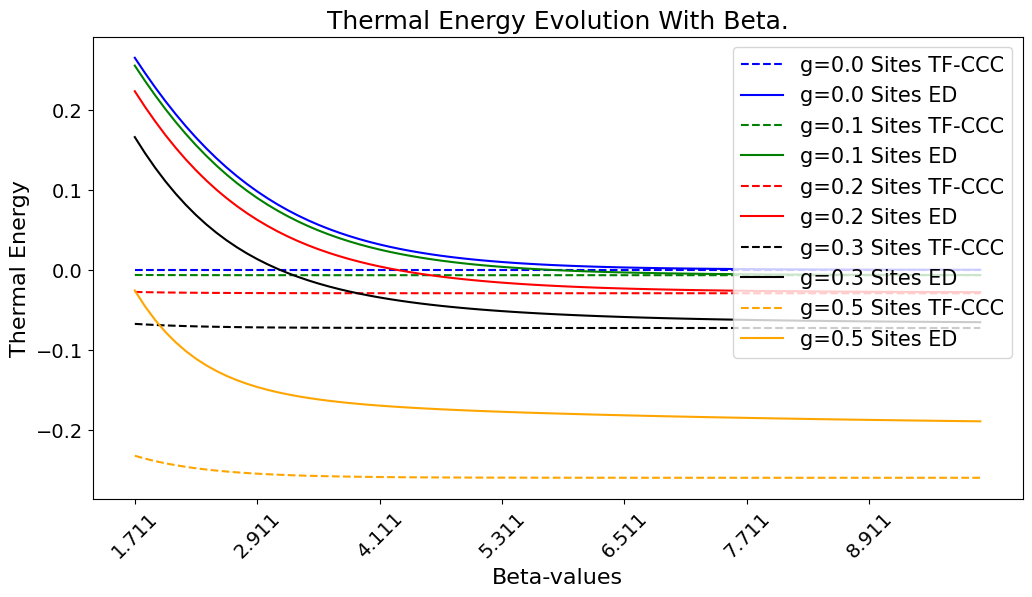

In [8]:
d = 20

plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 15,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for g_index, g in enumerate(g_array):
    plt.plot(beta_array[g_index][d:], -si5_st5_dB[g_index][d:]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
    # plt.plot(beta_array[g_index], -si5_st5_dB[g_index]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
    plt.plot(beta_array[g_index][d:], si5_st5_ED_U[g_index][d:]/site, label=f"g={g} Sites ED",  color=colours[g_index])
plt.xticks(beta_array[g_index][d:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Thermal Energy")
plt.title("Thermal Energy Evolution With Beta.", fontsize=18)
plt.legend(loc='upper right')
plt.show()

In [9]:
(-si5_st5_dB[g_index]/site)[0]

np.complex128(0.017659829638448192-0j)